In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj

NFF_PATH = '/home/wwj/Repo/playgrounds/NeuralForceField/'
ODE_PATH = '/home/wwj/Repo/projects/torchdiffeq/'

sys.path.insert(0, NFF_PATH)
sys.path.insert(0, ODE_PATH)
sys.path.insert(0, '../..')

import torch
from torch.optim import Adam
from torchdiffeq import odeint_adjoint as odeint
from torchmd.ode import ODE
from torchmd.hamiltoinians import PairPot, MLP, LennardJones
from torchmd.observable import DiffRDF
from torchmd.utils import dump_mov
from nglview import show_ase, show_file, show_mdtraj

from nff.utils.scatter import compute_grad
from nff.nn.layers import GaussianSmearing
from ase import Atoms

# Construct a Lattice for simulations 

In [3]:
import ase
from ase.neighborlist import neighbor_list
from ase.lattice.cubic import FaceCenteredCubic

DEVICE = 3
CUTOFF = 2.5
size = 3
atoms = FaceCenteredCubic(directions=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
                          symbol='H',
                          size=(size, size, size),
                          latticeconstant=0.8442 * 2,
                          pbc=True)
NATOMS = atoms.get_number_of_atoms()

mass = atoms.get_masses()

In [4]:
show_ase(atoms)

NGLWidget()

# Run MD and get training data

In [5]:
lj_params = {'epsilon': 1.0, 
             'sigma': 1.0}

model = PairPot(LennardJones, lj_params,
                cell=torch.Tensor(atoms.get_cell()).diag(), 
                device=DEVICE,
                cutoff=CUTOFF).to(DEVICE)

# model = PairPot(MLP, mlp_params,
#                 cell=torch.Tensor(atoms.get_cell()).diag(), 
#                 device=DEVICE,
#                 cutoff=CUTOFF).to(DEVICE)

In [6]:
xyz = torch.Tensor(atoms.get_positions()).to(DEVICE)
xyz.requires_grad=True

e = model(xyz)
#e.backward()

In [8]:
# declare position and momentum as initial values
xyz = torch.Tensor(atoms.get_positions())
xyz = xyz.reshape(-1)

# generate random velocity 
p = torch.rand(xyz.shape[0]) * 6#.to(DEVICE)
pq = torch.cat((p, xyz)).to(DEVICE)
pq.requires_grad= True

In [9]:
model = PairPot(LennardJones, lj_params, cell=torch.Tensor(atoms.get_cell()).diag(), device=DEVICE, cutoff=CUTOFF).to(DEVICE)
#model = PairPot(LennardJones, lj_params, cell=torch.Tensor(atoms.get_cell()).diag(), device=DEVICE, cutoff=CUTOFF).to(DEVICE)

In [10]:
%%time
f_x = ODE(model, mass, DEVICE).to(DEVICE)
t = torch.Tensor([0.05 * i for i in range(10)]).to(DEVICE)
x = odeint(f_x, pq, t)

CPU times: user 3.69 s, sys: 1.05 s, total: 4.74 s
Wall time: 4.87 s


In [11]:
movie = x[:, NATOMS*3:].reshape(-1, NATOMS, 3).detach().cpu().numpy()

In [16]:
dump_mov(movie, atoms)
traj = mdtraj.load_pdb("LJ.pdb") 
view = show_mdtraj(traj)

In [17]:
view.add_unitcell()

In [18]:
view

NGLWidget(max_frame=9)

In [1693]:
# Differentiable pair distributions 

In [32]:
Nbins = 32

dis_bin = torch.linspace(0, CUTOFF, Nbins + 1).to(DEVICE)
smear = GaussianSmearing(
                    start=0.0,
                    stop=dis_bin[-2],
                    n_gaussians=Nbins,
                    trainable=False
                ).to(DEVICE)

In [33]:
# systme parameters
PI = torch.Tensor([np.pi]).to(DEVICE)
cell = torch.Tensor(atoms.get_cell()).diag().to(DEVICE)
box_volume = torch.Tensor([atoms.get_volume()]).to(DEVICE)
vol = 4* PI /3*(dis_bin[1:]**3 - dis_bin[:-1]**3).to(DEVICE)
Natoms = atoms.get_number_of_atoms()

frames = x[:, Natoms*3:].reshape(-1, Natoms, 3)

rdf = DiffRDF(frames, cell, box_volume, dis_bin, smear, cutoff=CUTOFF, vol=vol, device=DEVICE, skip=1)

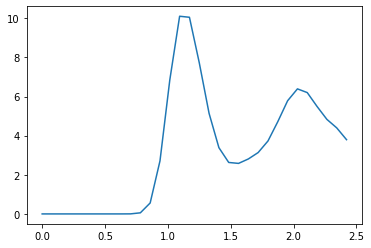

In [34]:
plt.plot(dis_bin[:-1].detach().cpu().numpy(), 
                rdf.detach().cpu().numpy())
#plt.plot(dis_bin[:-1].detach().cpu().numpy(), target_rdf)
plt.show()

In [35]:
np.save('rdf_3x3x3.npy', rdf.detach().cpu().numpy())
target_rdf = np.load('rdf_3x3x3.npy')

# Training 

11.509045600891113


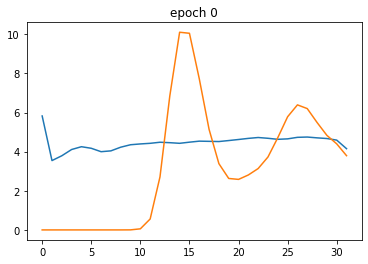

10.056242942810059


In [ ]:
# Wrap everyhing together: 
from datetime import datetime

# %%time

# define model

DEVICE = 3

lj_params = {'epsilon': 1.05, 
             'sigma': 0.8}

mlp_params = {'D_in': 1,
              'H': 32, 
              'num_layers': 2,
              'act': 'relu',
              'D_out': 1}

# model = PairPot(LennardJones, lj_params,
#                 cell=torch.Tensor(atoms.get_cell()).diag(), 
#                 device=DEVICE, 
#                 cutoff=CUTOFF).to(DEVICE)

model = PairPot(MLP, mlp_params,
                cell=torch.Tensor(atoms.get_cell()).diag(), 
                device=DEVICE, 
                cutoff=CUTOFF).to(DEVICE)

f_x = ODE(model, mass, DEVICE).to(DEVICE)

# define optimizer 
trainable_params = filter(lambda p: p.requires_grad, f_x.parameters())
#optimizer = torch.optim.SGD(trainable_params, lr=3e-4)
optimizer = torch.optim.Adam(trainable_params, lr=1e-2)

for i in range(200):
    
    current_time = datetime.now() 
    
    xyz = torch.Tensor(atoms.get_positions()).reshape(-1)
    # generate random velocity 
    p = torch.rand(xyz.shape[0]) * 6 #.to(DEVICE)
    print(p.pow(2).mean().item())

    pq = torch.cat((p, xyz)).to(DEVICE)
    pq.requires_grad= True
    t = torch.Tensor([0.05 * i for i in range(25)]).to(DEVICE)
    x = odeint(f_x, pq, t)
    
    frames = x[:, Natoms*3:].reshape(-1, Natoms, 3)
    rdf = DiffRDF(frames, cell, box_volume, dis_bin, smear, cutoff=CUTOFF, vol=vol, device=DEVICE, skip=5) 
    
    plt.title("epoch {}".format(i))
    plt.plot(rdf.detach().cpu().numpy())
    plt.plot(target_rdf)
    plt.show()
    
    loss = (rdf - torch.Tensor(target_rdf).to(DEVICE)).pow(2).mean()
    print(loss.item())
    loss.backward()
    
    dt = (datetime.now() - current_time)
    print( "{} seconds".format(dt.total_seconds())) 
    
    
    f_x.model.model.__class__ is LennardJones:
        print("epsilon: {}  sigma: {}".format(f_x.model.model.epsilon.item(), 
                                          f_x.model.model.sigma.item()))
    
    optimizer.step()
    optimizer.zero_grad()
    
    